# statistical experiments for Caspar-Cohen et al. 2021

In [1]:
import numpy as np
import xarray as xr
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt

import sstats.tseries as ts

In [2]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:54951 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.00 GiB


---

## wave associated displacements

See [Wagner and Young 2015](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/available-potential-vorticity-and-waveaveraged-quasigeostrophic-flow/A39B6FDC02763CD8B17A05AC83400C8B)

For a mode 1 wave, the Lagrangian mean flow is weaker than Stokes correction () by factor proportional to $kL$ where $k$ is the wave number and $L$ the spatial size of the enveloppe.

Recall:

$
\begin{align}
u_L = \bar u + u_S
\end{align}
$

where $u_L$ is the Lagrangian mean velocity,  $\bar u$ is the Eulerian mean, $u_S$ is the Stokes correction:

$
\begin{align}
u_S = \overline{ (\xi \cdot \nabla ) u}
\end{align}
$

where $\xi$ is the wave displacement. The displacement scales as $v/\omega$ and the Stokes correction scales as $v^2 k/\omega$.


---

## average of the phase term in (14)

$
\begin{align}
\Big \langle e^{i[\omega \tau - k \delta X(t,tau)]}  \Big \rangle
\end{align}
$

For a wave, the displacement is:

$
\begin{align}
\delta X(t,tau)] = \mathcal{R} \Big \{  \frac{\tilde{v}}{i\omega} (e^{i(\omega t- k X)}  \Big \}
\end{align}
$

In [3]:
?ts.exp_autocorr

Signature: ts.exp_autocorr(time, T, rms, draws=1, **kwargs)
Docstring:
Generate exponentially correlated time series
Implemented via ARMA
x_{t} = x_{t-1} * (1-dt/T) + \sqrt{2*dt/T}*rms *e_t

Parameters:
-----------
time: int, np.ndarray, tuple
    Number of time steps, time array, tuple (T, dt)
T: float, iterable
    Decorrelation time scales
rms: float, iterable
    Desired rms (not exact for each realization)
draws: int, optional
    Size of the ensemble, default to 1
seed: int, optional
    numpy seed
File:      ~/Code/synthetic_stats/sstats/tseries.py
Type:      function


In [4]:
x = ts.exp_autocorr((1000, 0.5 / 24), np.arange(10, 100, 10), 1, draws=100).rename("x")
x

<xarray.DataArray 'x' (tau: 9, draw: 100, time: 24000)>
dask.array<getitem, shape=(9, 100, 24000), dtype=float64, chunksize=(9, 50, 24000), chunktype=numpy.ndarray>
Coordinates:
  * tau      (tau) int64 10 20 30 40 50 60 70 80 90
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Attributes:
    rms:      1

### time series overview

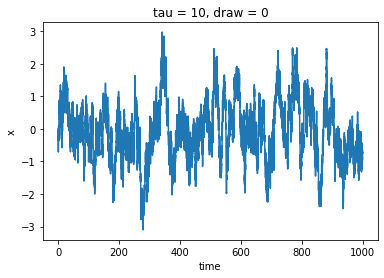

In [5]:
_x = x.sel(draw=0, tau=10)
_x.plot()
nlags = 24 * 500

### autocorrelation with sm

see [doc](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)

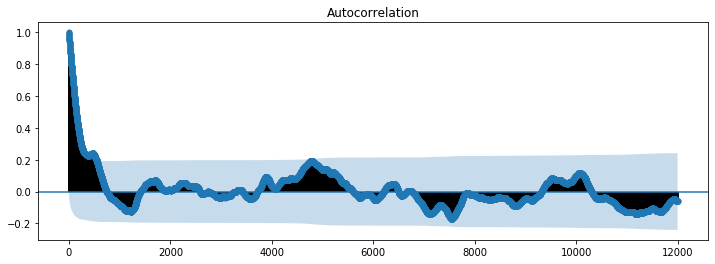

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
fig = sm.graphics.tsa.plot_acf(_x.squeeze(), lags=nlags, ax=ax)

### autocorrelation over whole dataset

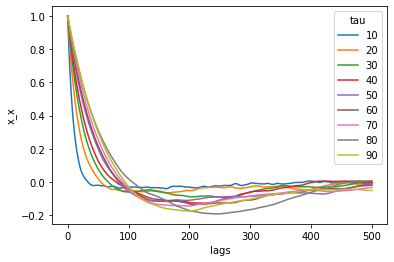

In [7]:
xx = ts.correlate(x, x).persist()
_ = (xx / xx.sel(lags=0)).mean("draw").plot.line(x="lags")

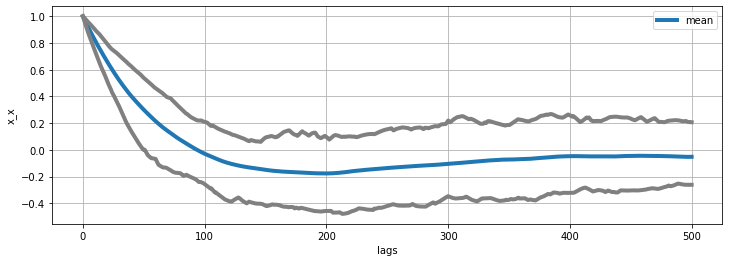

In [20]:
# focus on largest lag
def plot_correlation(_xx):
    _xx = _xx / _xx.sel(lags=0)
    mean = _xx.mean("draw")
    quantiles = [0.05, 0.95]
    qt = _xx.chunk(-1).quantile(q=quantiles, dim="draw").persist()

    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    mean.plot.line(x="lags", lw=4, add_legend=False, label="mean")
    qt.plot.line(x="lags", lw=4, color=".5")
    ax.grid()
    ax.legend()


plot_correlation(_xx=xx.isel(tau=-1))

---
## test sensibility to trend

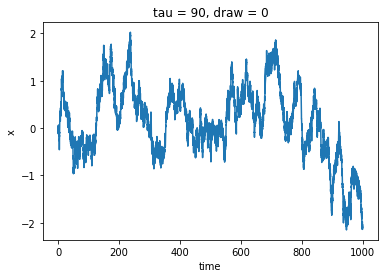

In [12]:
_x = x.sel(draw=0).isel(tau=-1)
_x.plot()

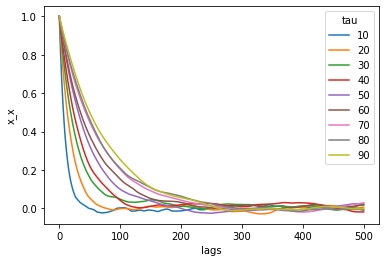

In [13]:
# without trend
xx_nodetrend = ts.correlate(x, x, detrend=False).persist()
_ = (xx_nodetrend / xx_nodetrend.sel(lags=0)).mean("draw").plot.line(x="lags")

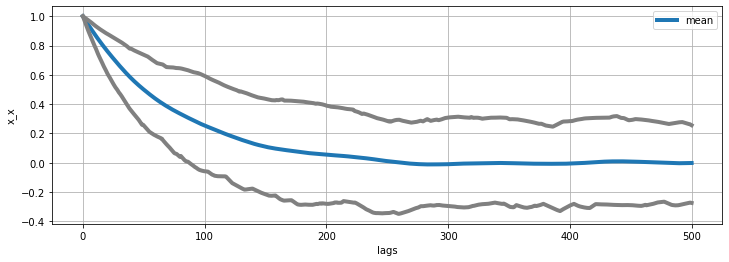

In [21]:
# focus on largest lag
plot_correlation(xx_nodetrend.isel(tau=-1))

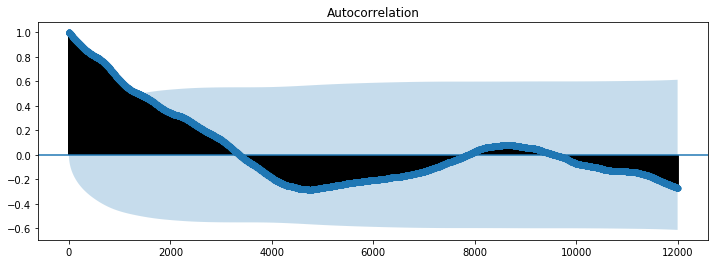

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
fig = sm.graphics.tsa.plot_acf(_x.squeeze(), lags=nlags, ax=ax)